In [54]:
import cv2
import numpy as np
import os

import datetime
from skimage import io
import os
import random
import matplotlib.pyplot as plt
import glob

In [55]:
# Starts capturing video
cap = cv2.VideoCapture(0)

fps = int(cap.get(cv2.CAP_PROP_FPS))

print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Captured Frame', frame)
    if cv2.waitKey(1) == ord('q'):
        break

    keypress = cv2.waitKey(1) & 0xFF

cap.release()
cv2.destroyAllWindows()

Frames per second using video.get(cv2.CAP_PROP_FPS) : 1


In [84]:
def segment(image, aWeight):
    # initialize the background
    bg = None

    # if the background is None, initialize it
    if bg is None:
        bg = image.copy().astype("float")
        return None

    # compute weighted average, accumulate it and update the background
    cv2.accumulateWeighted(image, bg, aWeight)

    # compute absolute difference between the background and current frame
    diff = cv2.absdiff(bg.astype("uint8"), image)

    # threshold the diff image so that we get the foreground
    thresholded = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)[1]

    # get the contours in the thresholded image
    cnts, _ = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return None
    else:
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)


In [57]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam


# model
model = Sequential()

# first conv layer
# input shape = (img_rows, img_cols, 1)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100,120, 1))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(6, activation='softmax'))

# model summary
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 118, 32)       320       
                                                                 
 batch_normalization_4 (Batc  (None, 98, 118, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 59, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 49, 59, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 57, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 47, 57, 64)      

In [58]:
# Loading the Dataset

DATASET_PATH = 'data'

dataset_path = os.path.join(DATASET_PATH, '*')
import glob
dataset_path = glob.glob(dataset_path)
dataset_path

['data/ok',
 'data/thumbsup',
 'data/blank',
 'data/thumbsdown',
 'data/fist',
 'data/five']

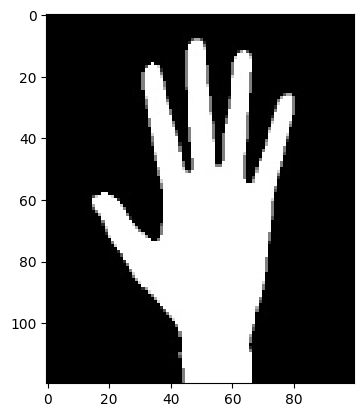

In [59]:
import cv2
image = cv2.imread('data/five/hand1(1015).jpg')
image = cv2.resize(image,(100, 120))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [60]:
loaded_images = []

list_of_gestures = ['blank', 'ok', 'thumbsup', 'thumbsdown', 'fist', 'five']

for path in range(0, len(dataset_path)):
    dataset_path = "data/" + str(list_of_gestures[path])
    gesture_path = os.path.join(dataset_path, '*')
    import glob
    gest_path = glob.glob(gesture_path)
    k = 0
    for i in range(0, len(gest_path)):
        if k < 1600:
            image = cv2.imread(gest_path[i])
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image,(100, 120))
            loaded_images.append(gray_image)
        k=k+1
print(len(loaded_images))

outputVectors = []
for i in range(1, 1601):
    outputVectors.append([1, 0, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 1, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 1, 0, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 1, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 1, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 0, 1])

print(len(outputVectors))

9600
9600


In [61]:
X = np.asarray(loaded_images)
y = np.asarray(outputVectors)
print(X.shape)
print(y.shape)

(9600, 120, 100)
(9600, 6)


In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train = X_train.reshape(X_train.shape[0], 100, 120, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 120, 1)
print(X_train.shape)
print(X_test.shape)

(7680, 100, 120, 1)
(1920, 100, 120, 1)


In [63]:
model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

model.save("hand_gesture_recognition.h5")

Epoch 1/10
60/60 [==============================] - 64s 1s/step - loss: 2.2889 - categorical_accuracy: 0.7056 - val_loss: 0.3175 - val_categorical_accuracy: 0.8776
Epoch 2/10
60/60 [==============================] - 65s 1s/step - loss: 0.3473 - categorical_accuracy: 0.8406 - val_loss: 0.1028 - val_categorical_accuracy: 0.9625
Epoch 3/10
60/60 [==============================] - 78s 1s/step - loss: 0.2859 - categorical_accuracy: 0.8602 - val_loss: 0.1056 - val_categorical_accuracy: 0.9646
Epoch 4/10
60/60 [==============================] - 61s 1s/step - loss: 0.2272 - categorical_accuracy: 0.8854 - val_loss: 0.0990 - val_categorical_accuracy: 0.9490
Epoch 5/10
60/60 [==============================] - 63s 1s/step - loss: 0.1978 - categorical_accuracy: 0.9010 - val_loss: 0.0419 - val_categorical_accuracy: 0.9870
Epoch 6/10
60/60 [==============================] - 62s 1s/step - loss: 0.1866 - categorical_accuracy: 0.9079 - val_loss: 0.0360 - val_categorical_accuracy: 0.9880
Epoch 7/10
60/60

In [64]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc))

60/60 [==============================] - 6s 100ms/step - loss: 0.0072 - categorical_accuracy: 0.9979
Accuracy: 0.9979166388511658


In [91]:
# load Model Weights

def _load_weights():
    try:
        model = load_model("hand_gesture_recog_model.h5")
        print(model.summary())
        # print(model.get_weights())
        # print(model.optimizer)
        return model
    except Exception as e:
        return None


    
def getPredictedClass(model):

    image = cv2.imread('Temp.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (100, 120))

    gray_image = gray_image.reshape(1, 100, 120, 1)

    prediction = model.predict_on_batch(gray_image)
    print(prediction)

    predicted_class = np.argmax(prediction)
    if predicted_class == 0:
        return "Blank"
    elif predicted_class == 1:
        return "OK"
    elif predicted_class == 2:
        return "Thumbs Up"
    elif predicted_class == 3:
        return "Thumbs Down"
    elif predicted_class == 4:
        return "Punch"
    elif predicted_class == 5:
        return "High Five"

if __name__ == "__main__":
    # initialize accumulated weight
    accumWeight = 0.5

    # get the reference to the webcam
    camera = cv2.VideoCapture(0)

    fps = int(camera.get(cv2.CAP_PROP_FPS))
    # region of interest (ROI) coordinates
    top, right, bottom, left = 10, 350, 225, 590
    # initialize num of frames
    num_frames = 0
    # calibration indicator
    calibrated = False
    model = _load_weights()
    k = 0
    # keep looping, until interrupted
    while (True):
        # get the current frame
        (grabbed, frame) = camera.read()

        # resize the frame
        frame = cv2.resize(frame, (700,700))
        # flip the frame so that it is not the mirror view
        frame = cv2.flip(frame, 1)

        # clone the frame
        clone = frame.copy()

        # get the height and width of the frame
        (height, width) = frame.shape[:2]

        # get the ROI
        roi = frame[top:bottom, right:left]

        # convert the roi to grayscale and blur it
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7, 7), 0)

        # to get the background, keep looking till a threshold is reached
        # so that our weighted average model gets calibrated
        if num_frames < 30:
            True
            # run_avg(gray, accumWeight)
            if num_frames == 1:
                print("[STATUS] please wait! calibrating...")
            elif num_frames == 29:
                print("[STATUS] calibration successfull...")
        else:
            # segment the hand region
            hand = segment(gray, accumWeight)

            # check whether hand region is segmented
            if hand is not None:
                # if yes, unpack the thresholded image and
                # segmented region
                (thresholded, segmented) = hand

                # draw the segmented region and display the frame
                cv2.drawContours(clone, [segmented + (right, top)], -1, (0, 0, 255))

                # count the number of fingers
                # fingers = count(thresholded, segmented)
                if k % (fps / 6) == 0:
                    cv2.imwrite('Temp.png', thresholded)
                    predictedClass = getPredictedClass(model)
                    cv2.putText(clone, str(predictedClass), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                # show the thresholded image
                cv2.imshow("Thesholded", thresholded)
        k = k + 1
        # draw the segmented hand
        cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)

        # increment the number of frames
        num_frames += 1

        # display the frame with segmented hand
        cv2.imshow("Video Feed", clone)

        # observe the keypress by the user
        keypress = cv2.waitKey(1) & 0xFF

        # if the user pressed "q", then stop looping
        if keypress == ord("q"):
            break

    # free up memory
    camera.release()
    cv2.destroyAllWindows()

[STATUS] please wait! calibrating...
